In [1]:
%pip install --quiet mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%pip install matplotlib
%matplotlib inline

In [3]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [4]:
#computes average knowledge of all students
def compute_avg_k(model):
  student_knowledge = [agent.knowledge for agent in model.schedule.agents if isinstance(agent, Student)]
  return np.mean(student_knowledge)
#gets knowledge of a specific student
def get_agent_knowledge(agent):
  if isinstance(agent, Student):
    return agent.knowledge
  else:
    return None


class Student(mesa.Agent):
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.knowledge = 0
    self.learning_rate = max(0.1, np.random.normal(0.5, 0.4))
  #increases knowledge by formula with learning rate, learning faster if teacher is within one square
  def learn(self):
    neighbors = self.model.grid.get_neighbors(self.pos, radius = 1, moore = True, include_center = False)
    teacher = self.model.schedule.agents[0]
    if teacher in neighbors:
      self.knowledge += 0.1 * self.learning_rate * teacher.teaching_rate
    else:
      self.knowledge += 0.1 * self.learning_rate

    self.knowledge = min(1, self.knowledge)

  def move(self):
    pass


class Teacher(mesa.Agent):
  def __init__(self, unique_id, model, t_rate):
    super().__init__(unique_id, model)
    self.teaching_rate = t_rate

  #looks for student with lowest knowledge and moves towards it if not already neighbors
  def move(self):
    student_knowledge = [(agent.knowledge, agent.pos) for agent in self.model.schedule.agents if isinstance(agent, Student)]
    if not student_knowledge:
      return
    target_student_pos = min(student_knowledge, key = lambda t: t[0])[1]
    neighbors = self.model.grid.get_neighborhood(self.pos, radius = 1,moore = True, include_center = False)
    if target_student_pos not in neighbors:
      self.model.grid.move_agent(self, self.calc_next_move(target_student_pos))

  #calculates direction of x and y movement to target position
  def calc_next_move(self, target_pos):
    x,y = self.pos
    tx, ty = target_pos

    dx = tx - x
    dy = ty-y

    if dx >0: dx = 1
    elif dx <0: dx = -1
    else: dx  = 0
    if (dy >0): dy = 1
    elif dy <0: dy = -1
    else: dy  = 0

    new_pos = (x + dx, y+dy)
    return new_pos

  def learn(self):
    pass


class Classroom(mesa.Model):
  def __init__(self, N, width, height, tt_rate):
    self.num_students = N
    self.grid = mesa.space.MultiGrid(width, height, False)
    #teacher moves first before students learn
    self.schedule = mesa.time.StagedActivation(self, ['move','learn'])
    self.running = True
    #places teacher in front and center of class
    teach = Teacher(0, self, tt_rate)
    self.schedule.add(teach)
    self.grid.place_agent(teach, (int(width/2),0))

    h = 1
    w = -1
    #adds students in in vertical row formation
    for i in range(1, self.num_students):
      stud = Student(i, self)
      self.schedule.add(stud)
      w += 2
      if (w >= width):
        w = 1
        h += 1
      self.grid.place_agent(stud,(w,h))
    #data collector reporting avg knowledge and each knowledge of student
    self.datacollector = mesa.DataCollector(
      model_reporters = {"Avg Knowledge": compute_avg_k}, agent_reporters = {"Knowledge": get_agent_knowledge}
    )


  def step(self):
    #stops running if all students have knowledge of 1
    if compute_avg_k(self) == 1:
      self.running = False
    self.datacollector.collect(self)
    self.schedule.step()





In [5]:
#interactive visualization of different numbers of students and teaching rates

from mesa.experimental import JupyterViz

def agent_portrayal(agent):
    size = 50
    color = "tab:red"
    layer = 0
    if isinstance(agent, Teacher):
        color = "tab:blue"
        layer = 1
    return {"size": size, "color": color, "layer": layer}

model_params = {
    "N": {
        "type": "SliderInt",
        "value": 26,
        "label": "Number of Students",
        "min": 10,
        "max": 40,
        "step": 1
    },
    "width": 10,
    "height": 10,
    "tt_rate" : {
        "type" : "SliderFloat",
        "value": 3,
        "label": "Teaching Rate",
        "min": 0.1,
        "max": 10,
        "step": 0.1
    }
}

page = JupyterViz(
    Classroom,
    model_params,
    measures = ["Avg Knowledge"],
    name = "Classroom Model",
    agent_portrayal = agent_portrayal

)
page

Html(layout=None, style_='display: none', tag='span')

Cannot show ipywidgets in text

In [6]:
#batch run of different numbers of students and diff teaching rates
params = {"width": 10, "height": 10, "N": range(10, 40, 2), "tt_rate": np.arange(0.1,10,0.2)}
results = mesa.batch_run(
    Classroom,
    parameters = params,
    iterations = 5,
    max_steps = 20,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True

)

100%|██████████| 3750/3750 [00:42<00:00, 87.69it/s] 


In [7]:
results_df = pd.DataFrame(results)
results_df.tail()


,RunId,iteration,Step,width,height,N,tt_rate,Avg Knowledge,AgentID,Knowledge
1887807,3749,4,20,10,10,38,9.9,0.791354,33,0.467000
1887808,3749,4,20,10,10,38,9.9,0.791354,34,0.446984
1887809,3749,4,20,10,10,38,9.9,0.791354,35,1.000000
1887810,3749,4,20,10,10,38,9.9,0.791354,36,1.000000
1887811,3749,4,20,10,10,38,9.9,0.791354,37,0.577642


In [8]:
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 20)]
results_filtered = results_filtered[["N", "tt_rate", "Avg Knowledge"]].reset_index(drop = True)


In [9]:
results_filtered.tail()

,N,tt_rate,Avg Knowledge
3682,38,9.1,0.862786
3683,38,9.3,0.852745
3684,38,9.5,0.803535
3685,38,9.7,0.828743
3686,38,9.9,0.791354


In [10]:
plt.clf()
gr = sns.scatterplot(data=results_filtered, x="N", y="tt_rate", hue = "Avg Knowledge", palette = "RdBu_r", size = "Avg Knowledge", sizes = (50, 200))
gr.set(title ="Heat Scatterplot of Avg Knowledge by Num of Students and Teaching Rate", xlabel = "Num Students", ylabel="Teaching Rate")
gr.legend(loc = 'upper left')

plt.savefig("Avg_Knowledge_Scatter.png")

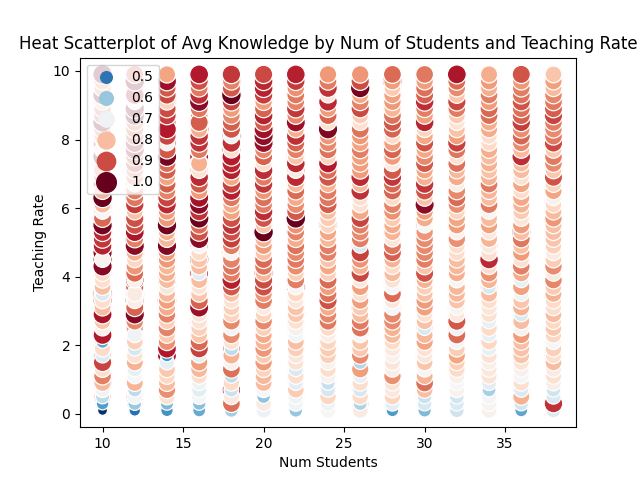

In [11]:
from IPython.display import Image

Image(filename="Avg_Knowledge_Scatter.png")